In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame

import matplotlib

import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'


## Damage cost for each scenario, year and labor type

In [2]:
pickle_in = \
open('../../output/productivity_results/impact_1000mc.pickle','rb')
impact_productivity = pickle.load(pickle_in) 

In [3]:
exposures = {}
categories = {'outside high physical activity':'OH','inside low physical activity':'IL',
                 'inside moderate physical activity':'IM','outside moderate physical activity':'OM'}
for category in categories:
    
    exposures[category] = Exposures()
    exposures[category].read_hdf5("".join(['../../input_data/exposures/exposures_productivity_ch_',categories[category],'.h5']))
    exposures[category].gdf['value'] = exposures[category].gdf['value']*8*52*5
    


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
exposures[category].crs

<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

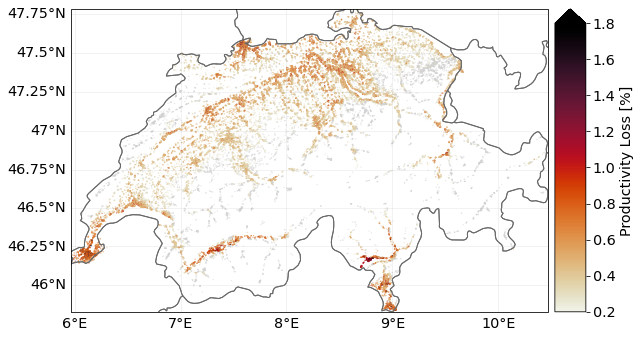

In [9]:
import cartopy.crs as ccrs
impact_high = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices['RCP85']['2050']['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=True, unit="Productivity Loss [%]")
impact_high.plot_hexbin_impact_exposure(pop_name=False,vmin=0.2, vmax=1.8,extend='max')
plt.savefig(''.join([fig_dir,'spatial_impact_2050_OH.pdf']),bbox_inches='tight')

In [6]:
categories = {'inside low physical activity': 'IL', 'inside moderate physical activity': 'IM',
                           'outside moderate physical activity': 'OM', 'outside high physical activity': 'OH'}
relative_matrices = impact_productivity.get_relative_change_matrices('2020', 'RCP85', categories)

In [11]:
relative_matrices

{'RCP26': {'2035': {'inside low physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'inside moderate physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'outside moderate physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'outside high physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>},
  '2050': {'inside low physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
   'inside moderate physical activity': <1x216100 sparse matrix of type '<class 'numpy.float64'>'
   	with 216100 stored elements in Compressed Sparse Row format>,
  

In [7]:
relative_matrice_high_rcp85 = impact_productivity.matrix_as_impact(relative_matrices['RCP85']['2050']['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=False, unit='Relative Change [%]')
relative_matrice_high_rcp26 = impact_productivity.matrix_as_impact(relative_matrices['RCP26']['2050']['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=False, unit='Relative Change [%]')


In [20]:
np.max(relative_matrices['RCP85']['2050']['outside high physical activity'])

85231.91202917152

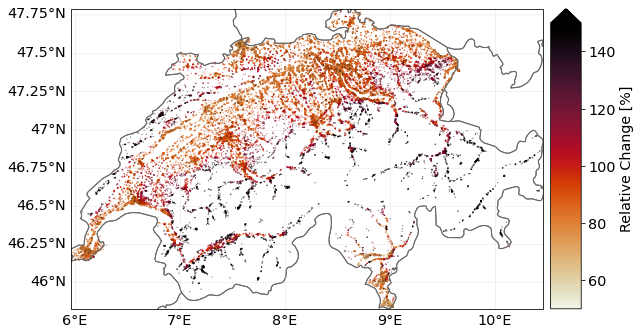

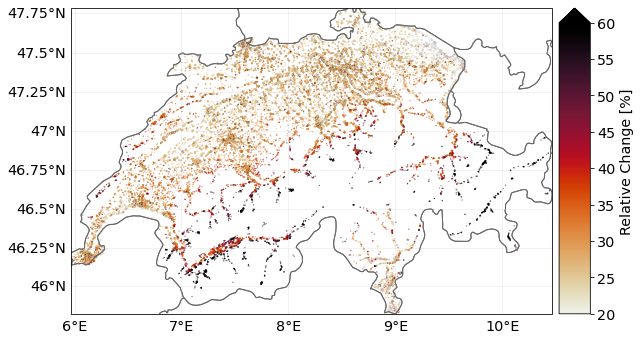

In [8]:
relative_matrice_high_rcp85.plot_hexbin_impact_exposure(pop_name=False, vmin=50, vmax=150, extend='max')
plt.savefig(''.join([fig_dir,'relative_change_2050_OH_rcp86.pdf']),bbox_inches='tight')

relative_matrice_high_rcp26.plot_hexbin_impact_exposure(pop_name=False,
                                                        vmin=20, vmax=60, extend='max')
plt.savefig(''.join([fig_dir,'relative_change_2050_OH_rcp26.pdf']),bbox_inches='tight')

In [4]:
from matplotlib import cycler
IPython_default = plt.rcParams.copy()
colors = cycler('color',
                       ['#EE6666', '#3388BB', '#9988DD',
                        '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='blue')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [64]:
(impact_productivity.agg_impacts_mc['RCP85']['2080'].median(axis=0).sum()-impact_productivity.agg_impacts_mc['RCP26']['2080'].median(axis=0).sum())/impact_productivity.agg_impacts_mc['RCP85']['2080'].median(axis=0).sum()


0.582873978705681

In [3]:
impact_productivity.costs_in_millions()



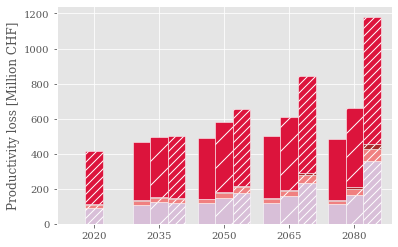

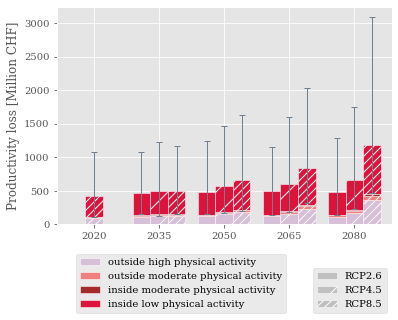

In [5]:
plt.rc('font', family='serif')
with plt.style.context('ggplot'):
    plot_impacts_heat(impact_productivity.agg_impacts_mc, 'Productivity loss [Million CHF]', impact_type='productivity', color=['thistle','lightcoral','brown','crimson'], save=True)


In [ ]:
plot_impacts_heat(impact_productivity.agg_impacts_mc, 'Productivity loss [Million CHF]', impact_type='productivity', color=['crimson','plum','red','orange'], save=True)


In [69]:
impact_productivity.median_impact_matrices

{}

In [38]:
print(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.05))/1000000)
print(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2020'].median()))
print(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.95))/1000000)


194.03292737607435
415375157.8083334
1629.6048616386624


In [16]:
print((np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.95))/(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.5)))))


2.907300794758943


In [52]:
total = np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'][cat].median() for cat in impact_productivity.agg_impacts_mc['RCP85']['2050'])
il_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['inside low physical activity'].median()/(exposures['inside low physical activity'].value.sum())
oh_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['outside high physical activity'].median()/(exposures['outside high physical activity'].value.sum())
om_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['outside moderate physical activity'].median()/(exposures['outside moderate physical activity'].value.sum())
im_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['inside moderate physical activity'].median()/(exposures['inside moderate physical activity'].value.sum())
total_percent = 100*total/((exposures['inside low physical activity'].value.sum()+exposures['outside high physical activity'].value.sum()+exposures['outside moderate physical activity'].value.sum()+exposures['inside moderate physical activity'].value.sum()))



/Users/zeliestalhanske/miniconda3/envs/climada_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [59]:
total_percent

0.14717568784890023

In [61]:
s = 'RCP85'
y='2050'

total = np.sum(impact_productivity.agg_impacts_mc[s][y][cat].mean() for cat in impact_productivity.agg_impacts_mc[s][y])

impact_productivity.agg_impacts_mc[s][y]['inside low physical activity'].median()/total



/Users/zeliestalhanske/miniconda3/envs/climada_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


0.5833517954761012

In [30]:
def median_death(impacts, scenario, year, category='all'):
    if category=='all':
        median_death = [np.median(impacts.agg_impacts_mc[scenario][year][cat]) for cat in impacts.agg_impacts_mc[scenario][year]]
    else:    
        median_death = np.median(impacts.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(impacts, scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(impacts, scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts.agg_impacts_mc[scenario][year][category])
    return median_death

In [32]:
(np.sum(median_death(impact_productivity, 'RCP26', '2050')) - np.sum(median_death(impact_productivity, 'RCP85', '2020')))/np.sum(median_death(impact_productivity, 'RCP85', '2020'))


0.17481619049432703

In [27]:
np.sum(median_death(impact_productivity, 'RCP85', '2050'))

679590607.5627055

## table with cantonal values

In [24]:
categories_short = {'inside low physical activity': 'IL', 'inside moderate physical activity': 'IM',
                           'outside moderate physical activity': 'OM', 'outside high physical activity': 'OH'}
impact_productivity.median_impact_matrices['RCP26']['2020']=impact_productivity.median_impact_matrices['RCP26']['2080']
cantonal_impacts_df = impact_productivity.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=['2020','2050','2080'])


In [14]:
cantonal_impacts_df

RCP2.6  \
                                                 2020   
                       outside high physical activity   
canton                                                  
Aargau                                   9.310301e+06   
Appenzell Ausserrhoden                   1.649499e+05   
Appenzell Innerrhoden                    6.488561e+04   
Basel-Landschaft                         4.647526e+06   
Basel-Stadt                              4.043616e+06   
Bern                                     1.001846e+07   
Fribourg                                 3.180278e+06   
Genève                                   1.134066e+07   
Glarus                                   3.270495e+05   
Graubünden                               2.275260e+06   
Jura                                     6.858639e+05   
Luzern                                   4.901316e+06   
Neuchâtel                                1.279678e+06   
Nidwalden                                3.756034e+05   
Obwalden                                 3.793351e+05   
Schaffhausen                             1.023680e+06   
Schwyz                                   1.471806e+06   
Solothurn                                3.359731e+06   
St. Gallen                               4.421679e+06   
Thurgau                                  2.779023e+06   
Ticino                                   8.725046e+06   
Uri                                      2.940254e+05   
Valais                                   4.944876e+06   
Vaud                                     8.579626e+06   
Zug                                      1.705807e+06   
Zürich                                   1.821698e+07   
Total                                    1.085171e+08   

                                                     \
                                                      
                       inside low physical activity   
canton                                                
Aargau                                 1.977762e+07   
Appenzell Ausserrhoden                 1.086207e+06   
Appenzell Innerrhoden                  2.843832e+05   
Basel-Landschaft                       9.678209e+06   
Basel-Stadt                            1.545477e+07   
Bern                                   3.706046e+07   
Fribourg                               8.202250e+06   
Genève                                 3.300993e+07   
Glarus                                 8.040674e+05   
Graubünden                             5.180068e+06   
Jura                                   1.971262e+06   
Luzern                                 1.375743e+07   
Neuchâtel                              5.367691e+06   
Nidwalden                              1.210277e+06   
Obwalden                               9.255728e+05   
Schaffhausen                           2.452592e+06   
Schwyz                                 4.419756e+06   
Solothurn                              7.748392e+06   
St. Gallen                             1.381131e+07   
Thurgau                                6.782296e+06   
Ticino                                 1.744979e+07   
Uri                                    6.926123e+05   
Valais                                 9.943634e+06   
Vaud                                   3.315151e+07   
Zug                                    7.119303e+06   
Zürich                                 8.166915e+07   
Total                                  3.390106e+08   

                                                          \
                                                           
                       inside moderate physical activity   
canton                                                     
Aargau                                      3.589822e+05   
Appenzell Ausserrhoden                      1.412018e+03   
Appenzell Innerrhoden                       5.463247e+02   
Basel-Landschaft                            1.849442e+05   
Basel-Stadt                                 1.919518e+05   
Bern                             

In [25]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5']['2020'])
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns='2020',level=1)
#print(cantonal_impacts_df_total)

In [26]:
cantonal_impacts_df_total = cantonal_impacts_df_total/1000000

In [66]:
cantonal_impacts_df_total=cantonal_impacts_df_total.round(decimals=2)

In [67]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))

\begin{tabular}{lrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{2}{l}{RCP2.6} & \multicolumn{2}{l}{RCP8.5} \\
{} &    2050 &    2080 &    2050 &     2080 \\
canton                 &                 &         &         &         &          \\
\midrule
Aargau                 &           26.99 &   31.89 &   31.07 &   42.70 &    77.15 \\
Appenzell Ausserrhoden &            1.06 &    1.23 &    1.28 &    1.75 &     3.21 \\
Appenzell Innerrhoden  &            0.30 &    0.35 &    0.36 &    0.50 &     0.96 \\
Basel-Landschaft       &           13.35 &   15.80 &   15.36 &   21.17 &    38.24 \\
Basel-Stadt            &           18.01 &   21.05 &   20.66 &   27.69 &    48.03 \\
Bern                   &           43.92 &   51.39 &   49.90 &   68.93 &   122.76 \\
Fribourg               &           10.47 &   12.32 &   11.91 &   16.72 &    30.24 \\
Genève                 &           41.64 &   49.14 &   47.33 &   65.89 &   118.29 \\
Glarus                 &            1.02 &    1.21 &    1.19 &  